## RESNET

In [27]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from resnet_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
#from test_utils import summary, comparator
#import public_tests

%matplotlib inline

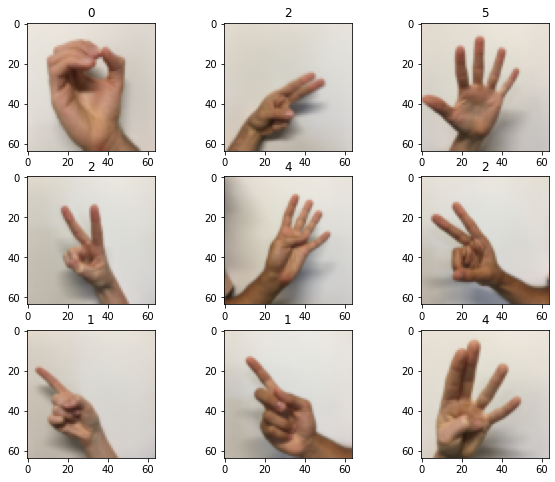

In [42]:
plt.figure(figsize=(10,8))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(X_train[i])
    plt.title(np.argmax(Y_train[i]))
    #plt.tight_layout()

In [13]:
def identity_block(X,f,filters,training=True,initializer=random_uniform):
    F1,F2,F3=filters
    
    X_shortcut=X
    
    X=Conv2D(filters=F1,strides=(1,1),kernel_size=1,padding='valid',kernel_initializer=initializer(seed=0))(X)
    X=BatchNormalization(axis=3)(X,training=training)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F2,strides=(1,1),kernel_size=(f,f),padding='same',kernel_initializer=initializer(seed=0))(X)
    X=BatchNormalization(axis=3)(X,training=training)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F3,strides=(1,1),kernel_size=1,padding='valid',kernel_initializer=initializer(seed=0))(X)
    X=BatchNormalization(axis=3)(X,training=training)
    
    X=Add()([X_shortcut,X])
    X=Activation('relu')(X)
    
    return X

In [14]:
def convolutional_block(X,f,filters,training=True,s=2,initializer=glorot_uniform):
    F1,F2,F3=filters
    
    X_shortcut=X
    
    X=Conv2D(filters=F1,strides=(s,s),kernel_size=1,padding='valid',kernel_initializer=initializer(seed=0))(X)
    X=BatchNormalization(axis=3)(X,training=training)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X=BatchNormalization(axis=3)(X,training=training)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F3,kernel_size=1,strides=(1,1),padding='valid',kernel_initializer=initializer(seed=0))(X)
    X=BatchNormalization(axis=3)(X,training=training)
    
    X_shortcut=Conv2D(filters=F3,kernel_size=1,strides=(s,s),padding='valid',kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut=BatchNormalization(axis=3)(X_shortcut,training=training)
    
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    
    return X

In [19]:
def ResNet50(input_shape=(64,64,3),classes=6):
    X_input=Input(input_shape)
    
    X=ZeroPadding2D((3,3))(X_input)
    
    X=Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding='valid',kernel_initializer=glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D(pool_size=(3,3),strides=(2,2))(X)
    
    X=convolutional_block(X,f=3,s=1,filters=[64,64,256])
    X=identity_block(X,f=3,filters=[64,64,256])
    X=identity_block(X,f=3,filters=[64,64,256])
    
    X=convolutional_block(X,f=3,s=2,filters=[128,128,256])
    X=identity_block(X,f=3,filters=[128,128,256])
    X=identity_block(X,f=3,filters=[128,128,256])
    X=identity_block(X,f=3,filters=[128,128,256])
    
    X=convolutional_block(X,f=3,s=2,filters=[256,256,1024])
    X=identity_block(X,f=3,filters=[256,256,1024])
    X=identity_block(X,f=3,filters=[256,256,1024])
    X=identity_block(X,f=3,filters=[256,256,1024])
    X=identity_block(X,f=3,filters=[256,256,1024])
    X=identity_block(X,f=3,filters=[256,256,1024])
    
    X=convolutional_block(X,f=3,s=2,filters=[512,512,2048])
    X=identity_block(X,f=3,filters=[512,512,2048])
    X=identity_block(X,f=3,filters=[512,512,2048])
    
    X=AveragePooling2D(pool_size=(2,2))(X)
    X=Flatten()(X)
    X=Dense(classes,activation='softmax',kernel_initializer=glorot_uniform(seed=0))(X)
    
    model=Model(inputs=X_input,outputs=X)
    
    return model
    

In [20]:
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result

In [21]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 70, 70, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 32, 32, 64)   9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 32, 32, 64)   256         conv2d_163[0][0]                 
____________________________________________________________________________________________

In [22]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [25]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
34/34 [==============================] - 43s 1s/step - loss: 1.7817 - accuracy: 0.5259
Epoch 2/20
34/34 [==============================] - 37s 1s/step - loss: 0.7049 - accuracy: 0.7796
Epoch 3/20
34/34 [==============================] - 38s 1s/step - loss: 0.2542 - accuracy: 0.9176
Epoch 4/20
34/34 [==============================] - 39s 1s/step - loss: 0.2805 - accuracy: 0.9102
Epoch 5/20
34/34 [==============================] - 38s 1s/step - loss: 0.2713 - accuracy: 0.9111
Epoch 6/20
34/34 [==============================] - 39s 1s/step - loss: 0.3280 - accuracy: 0.9093
Epoch 7/20
34/34 [==============================] - 38s 1s/step - loss: 0.2015 - accuracy: 0.9361
Epoch 8/20
34/34 [==============================] - 38s 1s/step - loss: 0.1969 - accuracy: 0.9389
Epoch 9/20
34/34 [==============================] - 39s 1s/step - loss: 0.0716 - accuracy: 0.9787
Epoch 10/20
34/34 [==============================] - 38s 1s/step - loss: 0.1676 - accuracy: 0.9519
Epoch 11/20
34/34 [

In [43]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 152ms/step - loss: 0.1476 - accuracy: 0.9667
Loss = 0.14763109385967255
Test Accuracy = 0.9666666388511658


In [79]:
img_path='HandSignTest3.jpeg'
img=image.load_img(img_path,target_size=(64,64))

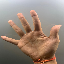

In [80]:
img

In [81]:
x=image.img_to_array(img)

In [82]:
x.shape

(64, 64, 3)

In [83]:
x=np.expand_dims(x,axis=0)

In [84]:
print('Input image shape is :',x.shape)

Input image shape is : (1, 64, 64, 3)


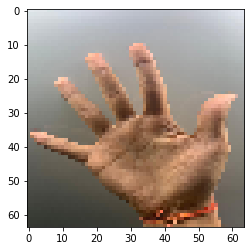

In [85]:
imshow(img)

In [86]:
prediction=model.predict(x)

In [89]:
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class: 5" )#np.argmax(prediction))

Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[9.9107271e-01 3.8356879e-06 4.3409378e-03 4.9406453e-04 2.5332095e-06
  4.0859589e-03]]
Class: 5


In [78]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 70, 70, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 32, 32, 64)   9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 32, 32, 64)   256         conv2d_163[0][0]                 
____________________________________________________________________________________________

## Bibliography

The implementation here took significant inspiration from the following papers

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - Deep Residual Learning for Image Recognition (2015)
Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py